In [104]:
import os
import gmaps
import gmaps.datasets
import config
import pandas as pd
import numpy as np
import time
from pygeocoder import Geocoder
# Try to move it to environement variables.
gmaps.configure(api_key=config.key)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Read Data

In [7]:
location = pd.read_csv('data/Gps.csv',names=["serial_no","id","time","long","lat"])
print(location.head())

   serial_no                id           time       long        lat
0    3435081  01ef64e4dec54025  1500138559805 -75.987328  42.108504
1    3435082  01ef64e4dec54025  1500138560805 -75.987328  42.108504
2    3435083  01ef64e4dec54025  1500138561807 -75.987328  42.108504
3    3435084  01ef64e4dec54025  1500138562810 -75.987328  42.108504
4    3435085  01ef64e4dec54025  1500138563813 -75.987328  42.108504


In [8]:
# GPS co-ordinates of the Garage.
start_lat  = 42.107844 
start_long = -75.987106

In [9]:
def pretty_time(raw):
    '''
    Converts time in epoch(milli seconds) to readable format.
    input: epoch time
    output: returns string formatted time
    '''
    return (time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(raw*.001)) )

print(pretty_time(location['time'][0]))

2017-07-15 13:09:19


### We have 4 different buses data in the same file.

In [10]:
bus_id = ( pd.DataFrame(location.groupby('id').count().reset_index()))
bus_id = bus_id['id']
print(bus_id)

0    01ef64e4dec54025
1    023d6dfce95b3997
2    024a0c2d305eb3cc
3    025391f6de955621
Name: id, dtype: object


## Filtering the Data.
* Removing rows which represent when the bus is parked in Garage

In [11]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [12]:
# Calculating distance from the garage.
location['distance'] = location.apply(lambda row: haversine(start_long,start_lat,row.long,row.lat),axis=1 )
print(location.shape)

(353020, 6)


In [55]:
# Removing locations at garage which are less than 0.2 km
location = location.drop( location[location.distance < 0.2].index )
location = location.drop(['serial_no'],axis=1)
print(location.shape)

(50890, 5)


### Categorizing different buses information.

In [57]:
bus1 = location[location['id']==bus_id[0]]
bus2 = location[location['id']==bus_id[1]]
bus3 = location[location['id']==bus_id[2]]
bus4 = location[location['id']==bus_id[3]]

# Analyzing Routes and Heatmaps

In [ ]:
# Only one bus was runing during this time.
route = bus4[ ['lat','long']].head(10000)
print(route)

In [133]:
bus4['lat_dif'] = bus4.lat - bus4.lat.shift(1)
bus4['lon_dif'] = bus4.long - bus4.long.shift(1)
print(bus4.iloc[0:60,:].describe())
print(bus4.iloc[70:130,:].describe())

               time       long        lat   distance    lat_dif    lon_dif
count  6.000000e+01  60.000000  60.000000  60.000000  59.000000  59.000000
mean   1.500123e+12 -75.990307  42.104183   0.486162  -0.000057  -0.000043
std    1.747507e+04   0.000757   0.001235   0.147930   0.000045   0.000040
min    1.500123e+12 -75.990976  42.102912   0.200184  -0.000127  -0.000125
25%    1.500123e+12 -75.990936  42.102966   0.363747  -0.000095  -0.000069
50%    1.500123e+12 -75.990605  42.103862   0.528591  -0.000066  -0.000036
75%    1.500123e+12 -75.989913  42.105321   0.628723  -0.000001  -0.000005
max    1.500123e+12 -75.988420  42.106331   0.632660   0.000022   0.000009
               time       long        lat   distance    lat_dif    lon_dif
count  6.000000e+01  60.000000  60.000000  60.000000  60.000000  60.000000
mean   1.500123e+12 -75.986252  42.100783   0.815635  -0.000074   0.000150
std    1.747600e+04   0.002684   0.001334   0.162672   0.000024   0.000017
min    1.500123e+12 -75.9

In [222]:
fig = gmaps.figure()
route_layer = gmaps.symbol_layer(route.iloc[370:390,:], fill_color="green", stroke_color="red", scale=1)
fig.add_layer(route_layer)
fig

In [64]:
fig = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer(route)
heatmap_layer.max_intensity = 100
heatmap_layer.point_radius = 13
fig.add_layer(heatmap_layer)
fig

In [229]:
gyro = pd.read_csv('data/Gyroscope.csv',names=['serial_no','device_id','time','x','y','z'])
gyro.drop(['serial_no'],axis=1,inplace=True)
gyro = gyro.drop( gyro[gyro['device_id']!= bus_id[3]].index)
print(gyro.head())

             device_id           time         x         y         z
5520  025391f6de955621  1500116381785 -0.000386  0.000360  0.000439
5521  025391f6de955621  1500116382786  0.000146 -0.000173 -0.000093
5522  025391f6de955621  1500116383787  0.000559 -0.000333 -0.000613
5523  025391f6de955621  1500116384788 -0.000506  0.000200 -0.000080
5524  025391f6de955621  1500116385789 -0.001039  0.000200  0.000453


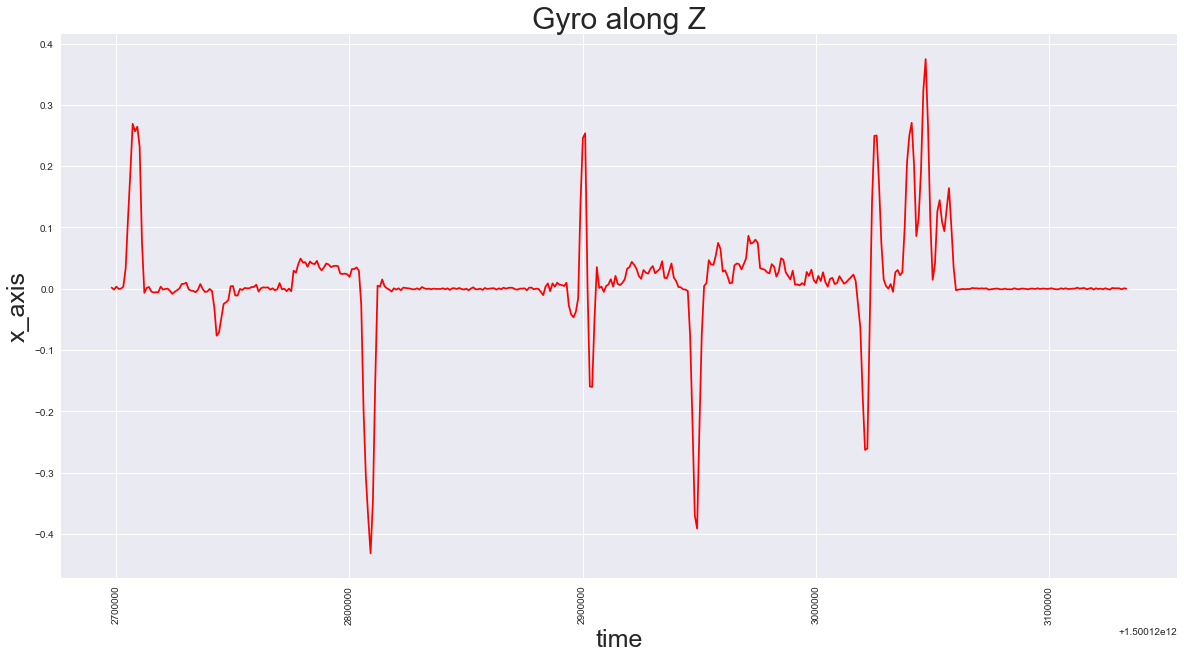

In [231]:
# bus4.iloc[55:75,:]
# First left turn indices
# print(bus4.iloc[55:75,:])
# second right turn 150-170
# third left turn(slightly smaller) 250-270
# 4th right turn 300-310
# 5th right 370-390
time1 = bus4['time'].iloc[55]
time2 = bus4['time'].iloc[490]
turning_points =  gyro[(gyro['time']>=time1) & (gyro['time']<=time2)]
plt.figure(figsize=(20,10))
# sns.set(font_scale=1) 
# sns.pointplot(gyro.easy_time.head(300),gyro.x.head(300))
plt.plot(turning_points.time,turning_points.z,color='r')
plt.xlabel('time', fontsize=25)
plt.ylabel('x_axis', fontsize=25)
plt.title("Gyro along Z", fontsize=30)
plt.xticks(rotation='vertical')
plt.show()

## Analyzing turns with Gyroscope

* +ve peak along gyroscope z axis indicates anti-clock wise turning of the phone or when the driver takes a left direction.
* Simliarly -ve peak indicating right turn.

So if we see the plot of the bus from Garage to the university main campus. The bus takes
    left
    right
    left
    right
    right ( onto parking space infront of union )
    left  ( adjusts vehicle onto the high plane )
    2 lefts ( indicating vehicle coming from slope infront of union to bus stop)

The intermediate small peaks might be the road not being well, when there are bumps on the road etc.

A threshold of +0.2 or -0.2 looks like agood value when indicating turns, the first left was in a curved manner so threshold was bit low. But second turn which was right was a more perpendicular turn so raising the peak to larger value.

We can loop over entire gyroscope to detect peaks which are greater than a threshold of absolute( gryo_z ) would give us number of turns the vehicle has taken.

## The Accelerometer Effect

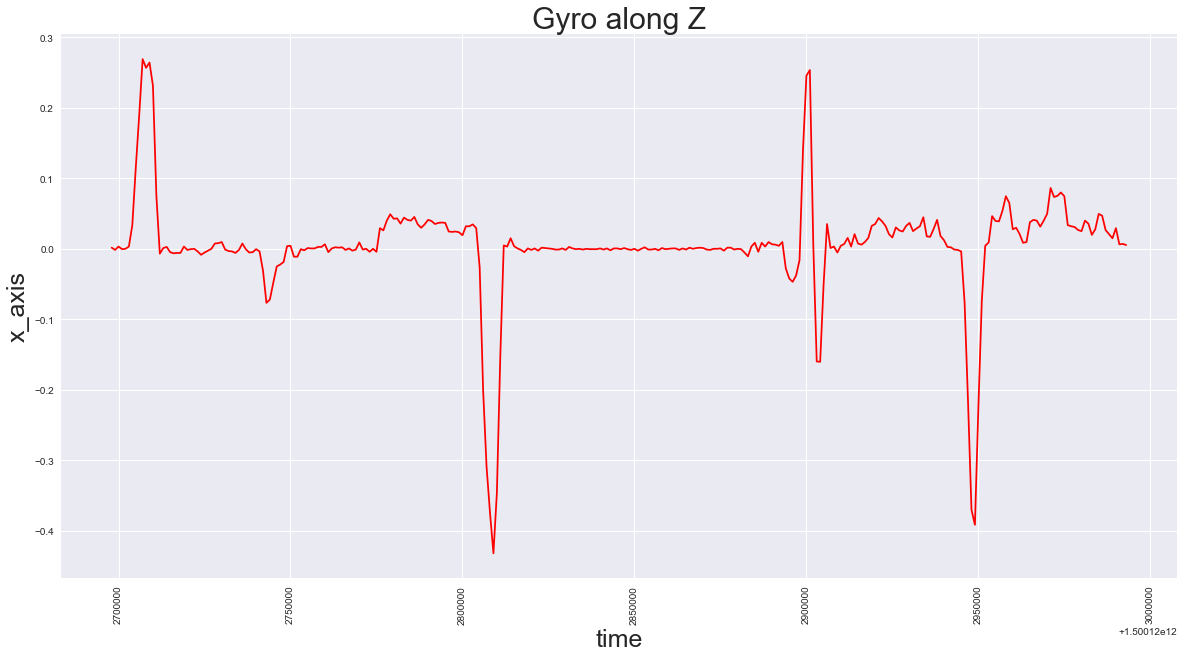

In [234]:
# Analyzing points in which bus travelled from Garage to university bus stop.
time1 = bus4['time'].iloc[55]
time2 = bus4['time'].iloc[350]
turning_points =  gyro[(gyro['time']>=time1) & (gyro['time']<=time2)]
plt.figure(figsize=(20,10))
# sns.set(font_scale=1) 
# sns.pointplot(gyro.easy_time.head(300),gyro.x.head(300))
plt.plot(turning_points.time,turning_points.z,color='r')
plt.xlabel('time', fontsize=25)
plt.ylabel('x_axis', fontsize=25)
plt.title("Gyro along Z", fontsize=30)
plt.xticks(rotation='vertical')
plt.show()